In [1]:
import logging
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from src.simulation import *
from src.rl import InverterEnv

logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [2]:

complete_series_csv = '../data/complete_series.csv'
df = pd.read_csv(complete_series_csv, parse_dates=['timestamp'])
prod_sim = EnergySim(max_step=7200, power_series=df.production_w)
cons_sim = EnergySim(max_step=6000, power_series=df.consumption_w, energy_type="consumption")
battery_wear_rate = 0
batt_sim = BatterySim(
    max_charge_rate=5000,
    max_discharge_rate=5000,
    capacity=10000,
    battery_wear_rate=battery_wear_rate,
    current_charge=10000
)
grid_sim = GridSim(
    feed_in_max=3500,
    feed_in_min=0,
    voltage_max=250,
    voltage_min=230,
    max_taken_from=6000,
    energy_price_sell=.1 / 1000,
    energy_price_buy=.4 / 1000,
    voltage_series=df.grid_voltage
)

inverter_sim = InverterSim(
    prod_sim=prod_sim,
    cons_sim=cons_sim,
    batt_sim=batt_sim,
    grid_sim=grid_sim,
    timestamps=df.timestamp.to_list(),
)
env = InverterEnv(inverter_sim, week)

In [3]:
def test_plot(env, steps=300, model=None):
    state_history = []
    obs, _ = env.reset()
    for _ in range(steps):
        action = 1
        if model:
            action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)

        state = list(env.state[:])
        state = state + list(env.calc_reward())
        state_history.append(state)
        if done:
            break
    state_df = pd.DataFrame(
        state_history,
        columns=[
            'production_energy',
            'consumption_energy',
            'battery_charged_energy',
            'battery_discharged_energy',
            'battery_stored_energy',
            'grid_feed_energy',
            'grid_taken_energy',
            'production_energy_24_last',
            'consumption_energy_24_last',
            'production_energy_24_next',
            'consumption_energy_24_next',
            'production_energy_24_next_skip',
            'consumption_energy_24_next_skip',
            'timestep_sin',
            'timestep_cos',
            'reward',
            'feed_in_reward',
            'purchase_penalty',
            'battery_wear_penalty'
        ]
    )

    print(
        f"{sum(state_df.reward):.1f}="
        f"{sum(state_df.feed_in_reward):.1f}"
        f"-{sum(state_df.purchase_penalty) :.1f}"
        f"-{sum(state_df.battery_wear_penalty):.1f}"
    )
    state_df.reward = state_df.reward * 40
    state_df = state_df[[
        #         'production_energy',
        #         'consumption_energy',
        #         'battery_charged_energy',
        #         'battery_discharged_energy',
        'battery_stored_energy',
        #         'grid_feed_energy',
        #         'grid_taken_energy',
        #             'production_energy_24_last',
        #             'consumption_energy_24_last',
        'production_energy_24_next',
        'consumption_energy_24_next',
        'production_energy_24_next_skip',
        'consumption_energy_24_next_skip',
        'timestep_sin',
        'timestep_cos',
        'reward'
    ]]
    plt.figure(figsize=(12, 8))
    for column in state_df.columns:
        plt.plot(state_df[column], label=column)
    plt.xlabel('Time Step')
    plt.ylabel('State Value')
    plt.legend()
    plt.title('State Evolution over Time Steps')
    plt.show()


In [19]:
class ConservativeModel:
    def predict(self, obs, *args, **kwargs):
        action = 1
        return action, {}


class GreedyModel:
    def predict(self, obs, *args, **kwargs):
        action = 0
        return action, {}


class SimpleModel:
    def __init__(self, lowerbound=60, upperbound=210):
        self.lowerbound = lowerbound
        self.upperbound = upperbound

    def predict(self, obs, *args, **kwargs):
        sin, cos = (obs[-2:] - .5) * 2
        timestep = np.arctan2(sin, cos) / np.pi / 2 * 288
        timestep = int(timestep if timestep > 0 else timestep + 288)
        action = 0 if timestep > self.lowerbound and timestep < self.upperbound else 1
        return action, {}

37.4=45.2-7.8-0.0


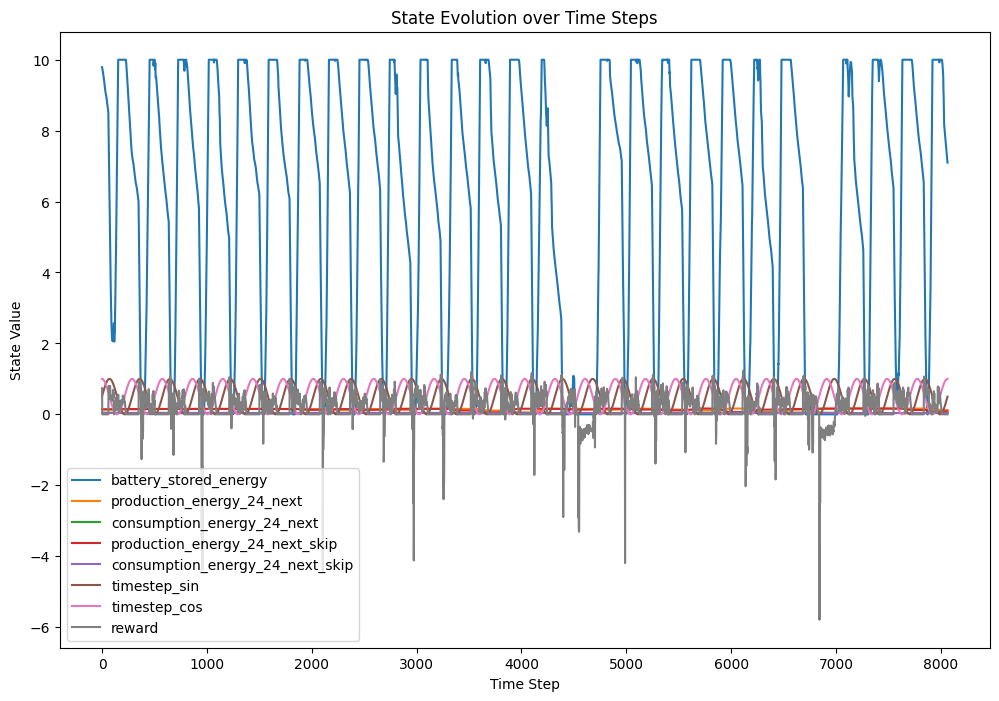

In [12]:
# env.max_steps = full_period

test_plot(
    env,
    # full_period,
    month,
    #     GreedyModel(),
    #     ConservativeModel(),
    SimpleModel(60, 210),
)

38.0=47.6-9.6-0.0


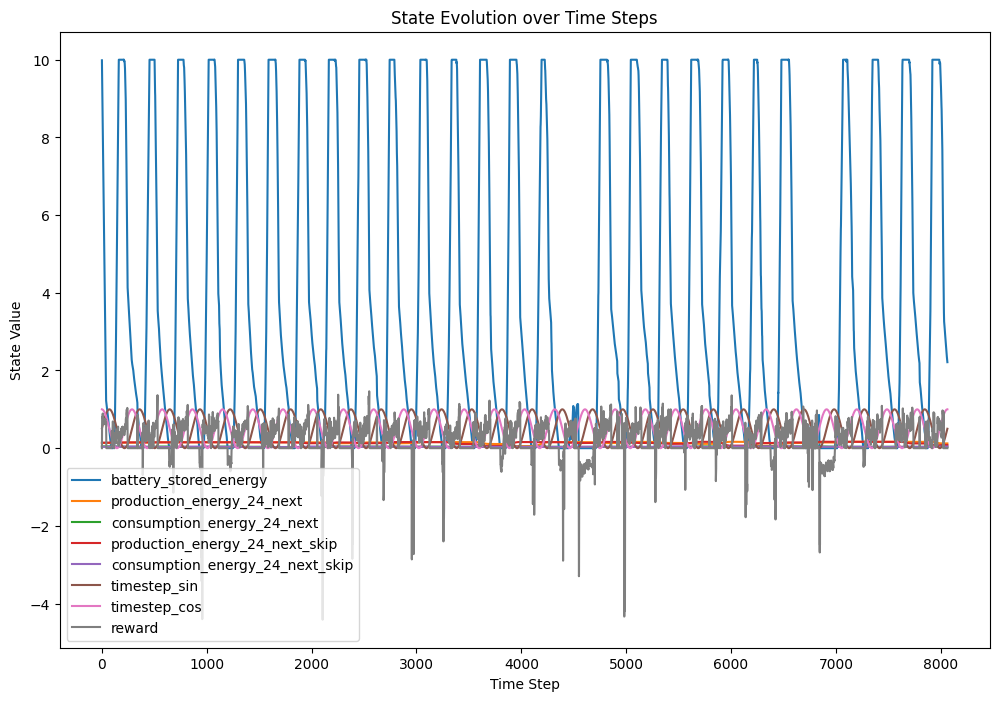

In [14]:
# model = PPO.load(
#     "../logs/models/ppo_inverter_best_15",
#     env=env
# )
test_plot(
    env,
    # full_period,
    month,
    # day,
    trained_model
)

In [7]:
from stable_baselines3.common.env_checker import check_env

check_env(env)
train_env = env
eval_callback = EvalCallback(
    train_env,
    best_model_save_path="../logs/best_model",
    log_path="../logs/results",
    eval_freq=full_period * 5,
    deterministic=True,
    render=False,
    verbose=1
)

In [8]:
trained_model = PPO(
    "MlpPolicy",
    train_env, 
    verbose=1,
    ent_coef=0.01, 
    learning_rate=0.003, 
    batch_size=2048,
)
train_env.reset()
trained_model.learn(
total_timesteps=1e6,
callback=eval_callback
)
trained_model.save(
"../logs/ppo_inverter"
)

In [13]:
train_env.max_steps=month
trained_model = PPO.load(
    "../logs/ppo_inverter", 
    env=train_env,
    verbose=0
)
trained_model.learn(
    total_timesteps=5e6,
    callback=eval_callback
)
trained_model.save(
    "../logs/ppo_inverter"
)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/emanuele/IdeaProjects/EnergyManagementRL/.venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=201600, episode_reward=35.17 +/- 0.00
Episode length: 8065.00 +/- 0.00
New best mean reward!
Eval num_timesteps=403200, episode_reward=32.82 +/- 0.00
Episode length: 8065.00 +/- 0.00
Eval num_timesteps=604800, episode_reward=39.69 +/- 0.00
Episode length: 8065.00 +/- 0.00
New best mean reward!
Eval num_timesteps=806400, episode_reward=33.79 +/- 0.00
Episode length: 8065.00 +/- 0.00
Eval num_timesteps=1008000, episode_reward=39.14 +/- 0.00
Episode length: 8065.00 +/- 0.00
Eval num_timesteps=1209600, episode_reward=41.74 +/- 0.00
Episode length: 8065.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1411200, episode_reward=38.56 +/- 0.00
Episode length: 8065.00 +/- 0.00
Eval num_timesteps=1612800, episode_reward=39.13 +/- 0.00
Episode length: 8065.00 +/- 0.00
Eval num_timesteps=1814400, episode_reward=35.63 +/- 0.00
Episode length: 8065.00 +/- 0.00
Eval num_timesteps=2016000, episode_reward=42.55 +/- 0.00
Episode length: 8065.00 +/- 0.00
New best mean reward!
Eval n

In [25]:
train_env.max_steps = full_period

In [ ]:
trained_model = PPO.load(
    "../logs/ppo_inverter",
    env=train_env,
    verbose=0
)
trained_model.learn(
    total_timesteps=full_period * 5 * 100,
    callback=eval_callback
)
trained_model.save("../logs/ppo_inverter")

174.3=174.9-0.5-0.0


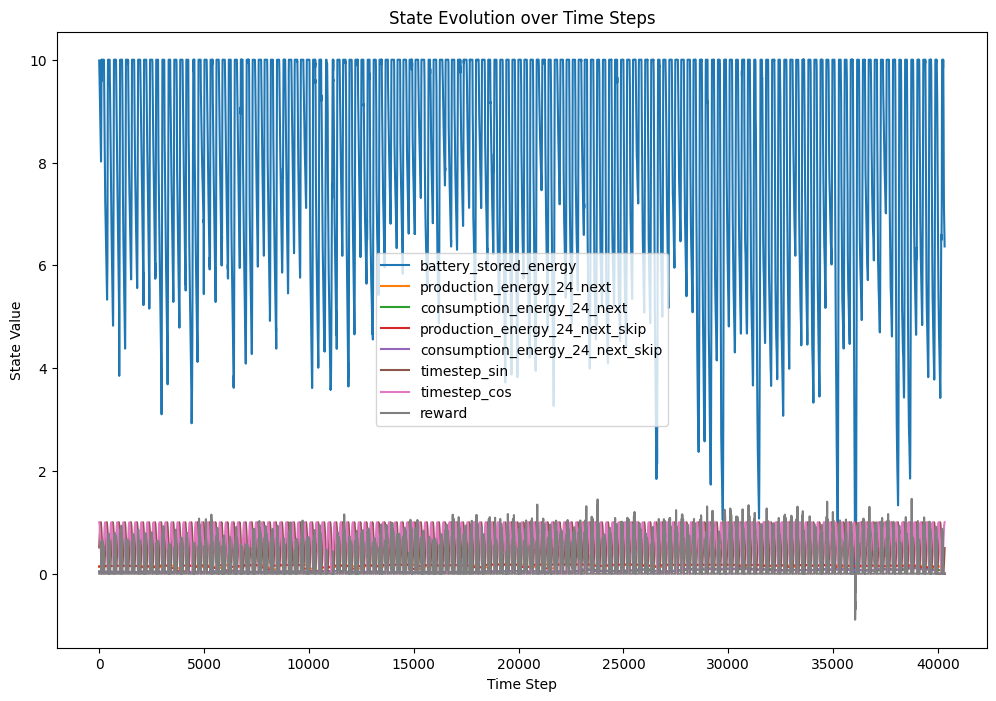

227.3=270.7-43.4-0.0


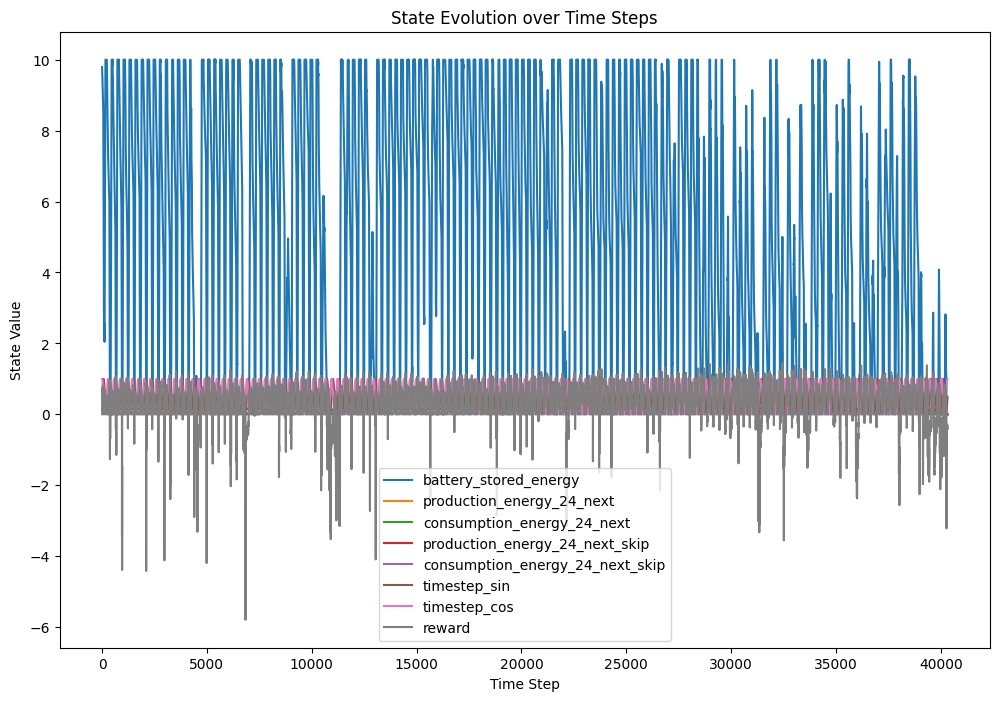

248.2=269.4-21.2-0.0


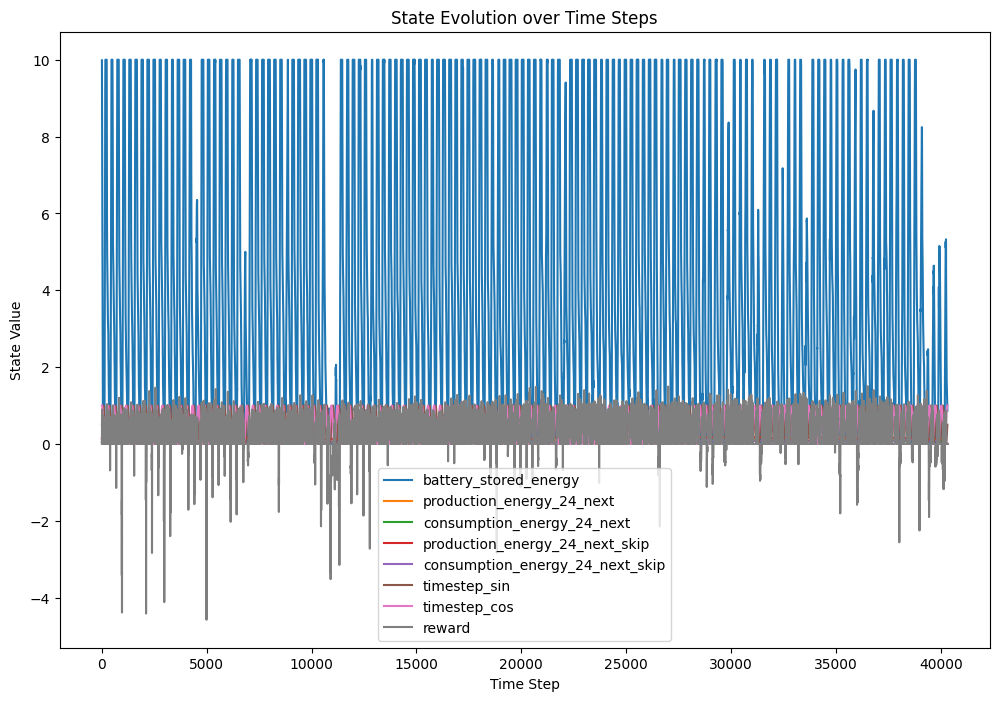

In [26]:
trained_model = PPO.load(
    "../logs/best_model/best_model.zip",
    env=train_env
)
for model_to_test in [ConservativeModel(), SimpleModel(), trained_model]:
    test_plot(
        train_env,
        full_period,
        # month,
        # week,
        model_to_test
    )

In [24]:
trained_model.save("../logs/ppo_inverter_0")